<a href="https://colab.research.google.com/github/rammeshulam/ml-exercise/blob/main/Recommender_systems_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender Systems

This exercise is focused on recommender systems, with the following questions:
1. Warm-up Exercise: Predict movie ratings.
    - This involves using a dataset of movie ratings to predict the rating a user might give to a specific movie they haven't rated yet.
    -  Evaluation of the prediction quality is performed using RMSE (Root Mean Squared Error).
2. Generating Top-k Recommendations:
    - Develop recommendation systems to suggest relevant movies to users.
    - Explore several recommendation approaches, including:
        - Non-personalized recommendations (based on IMDB weighted rating).
        - Item-based collaborative filtering (recommending movies similar to movies the user has liked).
        - User-based collaborative filtering (recommending movies liked by similar users).
        - Content-based filtering (recommending movies based on movie's content similarity)
    -  Evaluate and compare the performance of different recommendation approaches.

Interesting lunks:

* [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) - Calculates the **average squared difference** between predicted and actual values.
* [`jaccard_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) - Computes the Jaccard index, a measure of **set similarity**. It is defined as the size of the intersection divided by the size of the union of two label sets
* [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) - Measures the cosine similarity between vectors, **indicating direction similarity**.
* [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) - Splits arrays or matrices into random train and test subsets for **model evaluation**.
* [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) - Transforms text into a matrix of TF-IDF features, **weighting word importance**.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

import requests
import zipfile
import io

import matplotlib.pyplot as plt

# 1 Warm up exercise - predict ratings
In this exercise you will work with a small dataset of 100,000 ratings, done by ~600 users across ~9,700 movies.

## 1.0 load and prepare data
* Load data,
* merge movie details and ratings to one dataframe
* re-indexing userIds and movieIds to consecutive numbers

In [ ]:
url = "https://www.kaggle.com/api/v1/datasets/download/gargmanas/movierecommenderdataset"
response = requests.get(url, stream=True)

z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

print("Movies DataFrame:")
print(movies.head())

print("\nRatings DataFrame:")
print(ratings.head())


Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings DataFrame:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
df = ratings.merge(movies, on='movieId', how='left')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# Change movie Ids to have consecutive numbers on df

# Create a mapping from old movie IDs to new consecutive IDs
unique_movie_ids = df['movieId'].unique()
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_movie_ids)}

# Replace old movie IDs with new consecutive IDs in the DataFrame
df['movieId'] = df['movieId'].map(movie_id_map)

#start userId from 0
if min(df['userId'])==1:
   df['userId'] = df['userId']-1

#Calculate unique users, ratings and movies
n_users = df['userId'].nunique()
n_ratings = len(df)
n_movies = df['movieId'].nunique()

print(f"There are {n_users} unique users, with {n_ratings} ratings across {n_movies} movies")

df.head()

There are 610 unique users, with 100836 ratings across 9724 movies


,userId,movieId,rating,timestamp,title,genres
0,0,0,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0,1,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,0,2,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,0,3,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,0,4,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,325.127564,1855.988248,3.501557,1.205946e+09
std,182.618491,2000.247662,1.042529,2.162610e+08
min,0.000000,0.000000,0.500000,8.281246e+08
25%,176.000000,461.000000,3.000000,1.019124e+09
50%,324.000000,1134.000000,3.500000,1.186087e+09
75%,476.000000,2510.000000,4.000000,1.435994e+09
max,609.000000,9723.000000,5.000000,1.537799e+09


## 1.1 Benchmark - mean user rating

* Split the data to train (80%) and test (20%).
* For each user calculate average rating, based on the train data
* For each user, use the average rating as predicted rating for all movies in test set. For users with no ratings,  predict the global average score across all users
* calculate RMSE for the predictions. This is the benchmark score.

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
global_avg = train_data['rating'].mean()
print(f"Global average rating: {round(global_avg,2)}")

user_avg_ratings = train_data.groupby('userId')['rating'].mean()
user_avg_ratings.head()

Global average rating: 3.5


,rating
userId,
0,4.331606
1,3.920000
2,2.580645
3,3.464706
4,3.657895


In [ ]:
# Create predictions for the test data
mean_predictions = test_data['userId'].map(user_avg_ratings)

# Fill NaN values in 'prediction' with the global average
mean_predictions.fillna(global_avg, inplace=True)

# Calculate the MSE score
mse_score = mean_squared_error(test_data['rating'], mean_predictions)

print(f"RMSE: {round(np.sqrt(mse_score),4)}")


RMSE: 0.9497


## 1.2 User based rating prediction
* Convert the train_data to a matrix of shape n_usersXn_movies. cell [x,y] of the matrix holds the rating of user x for movie y, or 0 if the user did not rate this movie on train_data. Name it **train_matrix**

* Calculate cosine similarity betwen the rows (i.e., users) of train_matrix.The result is a matrix of shape n_usersXn_users. The cell x,y holds the cosine similarity of user x and user y. Name it **user_similarity**

* apply the function user_based_prediction() to predict the ratings in the test_data and calculate RMSE


## 1.3 Item based rating prediction
* Simiar to user_similarity, calculate item_similarity as follows. To calculate item similarity, use the transpose matrix (train_matrix.T). Calculate cosine similarity betwen the rows (i.e., items) of train_matrix.T .The result is a matrix of shape n_moviesXn_movies. The cell x,y holds the cosine similarity of movie x and movie y. Name it **item_similarity**

* apply the function item_based_prediction() to predict the ratings in the test_data and calculate RMSE


In [ ]:
# Create train_matrix of size users x movies. The matrix hold the userXmovie ratings from train data. Ensure that the shape of the matrices is 610x9724
train_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_matrix[line[1], line[2]] = line[3]

print(f"Shape of train_matrix: {train_matrix.shape}")

Shape of train_matrix: (610, 9724)


In [ ]:
# Calculate user and item similarities tables

user_similarity = cosine_similarity(train_matrix)
item_similarity = cosine_similarity(train_matrix.T)

print(f"User Similarity Matrix - userXuser, shape:{user_similarity.shape}):")
print(user_similarity)

print(f"\n\nItem Similarity Matrix - itemXitem, shape:{item_similarity.shape}):")
item_similarity


User Similarity Matrix - userXuser, shape:(610, 610)):
[[1.         0.01631391 0.04902077 ... 0.23281083 0.11217366 0.14390178]
 [0.01631391 1.         0.         ... 0.05561043 0.0324038  0.0758095 ]
 [0.04902077 0.         1.         ... 0.00943339 0.         0.03130872]
 ...
 [0.23281083 0.05561043 0.00943339 ... 1.         0.11037068 0.26088589]
 [0.11217366 0.0324038  0.         ... 0.11037068 1.         0.05797092]
 [0.14390178 0.0758095  0.03130872 ... 0.26088589 0.05797092 1.        ]]


Item Similarity Matrix - itemXitem, shape:(9724, 9724)):


array([[1.        , 0.19173834, 0.27868004, ..., 0.09522082, 0.09522082,
        0.09522082],
       [0.19173834, 1.        , 0.17774771, ..., 0.        , 0.        ,
        0.        ],
       [0.27868004, 0.17774771, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09522082, 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.09522082, 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.09522082, 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
# Calculate the percentage of zero values in user_similarity
user_similarity_zero_percentage = (np.sum(user_similarity == 0) / user_similarity.size) * 100

# Calculate the percentage of zero values in item_similarity
item_similarity_zero_percentage = (np.sum(item_similarity == 0) / item_similarity.size) * 100

print(f"Percentage of zero values in user_similarity matrix: {user_similarity_zero_percentage:.2f}%")
print(f"Percentage of zero values in item_similarity matrix: {item_similarity_zero_percentage:.2f}%")


Percentage of zero values in user_similarity matrix: 16.50%
Percentage of zero values in item_similarity matrix: 79.25%


In [ ]:
def user_based_prediction(user_id, movie_id, user_similarity, train_matrix):
    """
    Predicts the rating of a movie for a user based on user-based collaborative filtering.
    Only considers users who have rated the target movie.

    Args:
        user_id: The index of the user in the user-similarity matrix.
        movie_id: The index of the movie in the train_matrix.
        user_similarity: The user-similarity matrix.
        train_matrix: The training matrix.

    Returns:
        The predicted rating for the movie.
    """
    # Find users who have rated the target movie
    rated_users_idx = np.where(train_matrix[:, movie_id] != 0)[0]

    # Get similarity scores only for those users
    # #note due to sparsness of user similarity matrix, [movie_id, rated_movies_idx] may be all zeros
    user_sim_scores = user_similarity[user_id, rated_users_idx]

    # Get ratings of those users for the target movie
    user_rated_movies = train_matrix[rated_users_idx, movie_id]

    # Calculate weighted average (avoid division by zero)
    if np.sum(np.abs(user_sim_scores)) == 0:
        return user_avg_ratings[user_id]  # some default value if no similar users have rated
    else:
        user_based_prediction = np.sum(user_sim_scores * user_rated_movies) / np.sum(np.abs(user_sim_scores))
        return user_based_prediction

In [ ]:
def item_based_prediction(user_id, movie_id, item_similarity, train_matrix):
    """
    Predicts the rating of a movie for a user based on item-based collaborative filtering.
    Only considers movies that the user has rated.

    Args:
        user_id: The index of the user in the user-similarity matrix.
        movie_id: The index of the movie in the train_matrix.
        item_similarity: The item-similarity matrix.
        train_matrix: The training matrix.

    Returns:
        The predicted rating for the movie.
    """
    # Find movies that the target user has rated
    rated_movies_idx = np.where(train_matrix[user_id, :] != 0)[0]

    # Get similarity scores only for those movies
    #note due to sparsness of item similarity matrix, [movie_id, rated_movies_idx] may be all zeros
    item_sim_scores = item_similarity[movie_id, rated_movies_idx]

    # Get ratings of the target user for those movies
    user_rated_movies = train_matrix[user_id, rated_movies_idx]

    # Calculate weighted average (avoid division by zero)
    if np.sum(np.abs(item_sim_scores)) == 0:
        return user_avg_ratings[user_id]  # as a default, return average user rating
    else:
        item_based_prediction = np.sum(item_sim_scores * user_rated_movies) / np.sum(np.abs(item_sim_scores))
        return item_based_prediction


In [ ]:
# Lists to store predictions and actual ratings for both methods
predictions_user_based = []
predictions_item_based = []
actual_ratings = []

for line in test_data.itertuples():
    user_id = line[1]
    movie_id = line[2]
    actual_rating = line[3]

    # User-based prediction
    predicted_rating_user = user_based_prediction(user_id, movie_id, user_similarity, train_matrix)
    predictions_user_based.append(predicted_rating_user)

    # Item-based prediction
    predicted_rating_item = item_based_prediction(user_id, movie_id, item_similarity, train_matrix)
    predictions_item_based.append(predicted_rating_item)

    actual_ratings.append(actual_rating)


# Calculate RMSE for user-based prediction
rmse_user_based = np.sqrt(mean_squared_error(actual_ratings, predictions_user_based))
print(f"User-based RMSE: {rmse_user_based}")

# Calculate RMSE for item-based prediction
rmse_item_based = np.sqrt(mean_squared_error(actual_ratings, predictions_item_based))
print(f"Item-based RMSE: {rmse_item_based}")

User-based RMSE: 0.9692684392311044
Item-based RMSE: 0.9224760065256074


In [ ]:
#Show actual, predicted and diff for both models

results_df = pd.DataFrame({
    'Actual': actual_ratings,
    'Predicted_UserBased': predictions_user_based,
    'Predicted_ItemBased': predictions_item_based,
    'Diff_UserBased': np.array(predictions_user_based) - np.array(actual_ratings),
    'Diff_ItemBased': np.array(predictions_item_based) - np.array(actual_ratings)
})

results_df.head()


,Actual,Predicted_UserBased,Predicted_ItemBased,Diff_UserBased,Diff_ItemBased
0,4.5,2.911014,3.622180,-1.588986,-0.877820
1,3.0,3.737385,3.220562,0.737385,0.220562
2,3.0,3.259068,2.733470,0.259068,-0.266530
3,4.0,3.601742,3.654397,-0.398258,-0.345603
4,4.0,3.814058,3.290633,-0.185942,-0.709367


# 2 Top-k recommendations: Item, User and Conent based

In this exercise you will process ~10,000,000 ratings. The goal is to recommend top-k movies.

## 2.0 Load and prepare data

### 2.0.1 Load data

In [ ]:
# Download the zip file
url = 'https://www.kaggle.com/api/v1/datasets/download/grouplens/movielens-20m-dataset'
response = requests.get(url, stream=True)


# Extract the zip file contents into memory
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Extract dataframes
genome_scores = pd.read_csv(zip_file.open('genome_scores.csv'))
ratings = pd.read_csv(zip_file.open('rating.csv'))
genome_tags = pd.read_csv(zip_file.open('genome_tags.csv'))
#links = pd.read_csv(zip_file.open('link.csv'))
movies = pd.read_csv(zip_file.open('movie.csv'))
tags = pd.read_csv(zip_file.open('tag.csv'))


# Print the first few rows of each dataframe to verify
print("Genome Scores:")
print(genome_scores.head())
print("\nRatings:")
print(ratings.head())
print("\nGenome Tags:")
print(genome_tags.head())
#print("\nLinks:")
#print(links.head())
print("\nMovies:")
print(movies.head())
print("\nTags:")
print(tags.head())


Genome Scores:
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675

Ratings:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

Genome Tags:
   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0 

### 2.0.2 clean data

In [ ]:
df = movies.merge(ratings, how="left", on="movieId")

In [ ]:
movie_counts = df.groupby('movieId')['rating'].count()
filtered_movies = movie_counts[movie_counts >= 1000].index
df_known = df[df['movieId'].isin(filtered_movies)]

print(f"Original data: {len(ratings):,} ratings on {len(movies):,} movies.")
print(f"Filtered data: {len(df_known):,} ratings on {len(df_known['movieId'].unique()):,} movies.")
df_known.head()


Original data: 20,000,263 ratings on 27,278 movies.
Filtered data: 17,765,516 ratings on 3,159 movies.


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


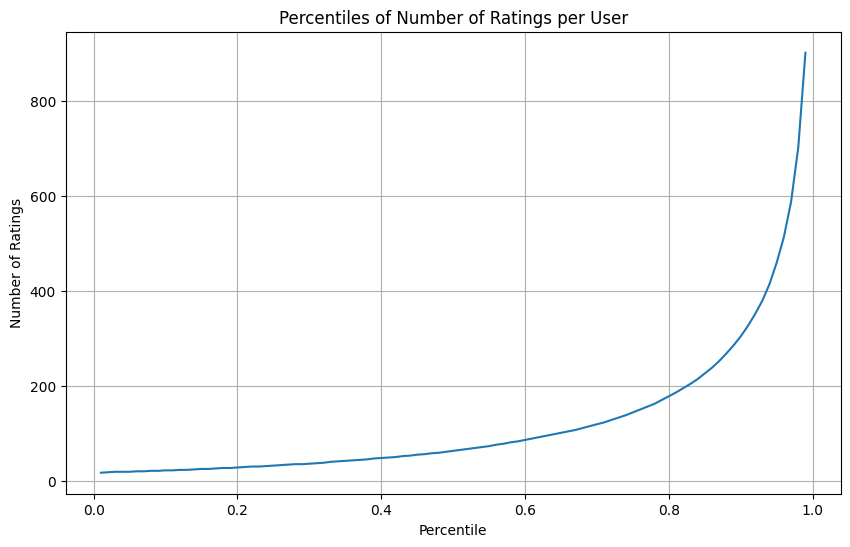

In [ ]:
# Calculate the number of ratings per user
user_ratings = df_known.groupby('userId')['rating'].count()

# Calculate percentiles
percentiles = np.arange(0.01, 1, 0.01)
percentile_values = np.percentile(user_ratings, percentiles * 100)

# Plot the percentiles
plt.figure(figsize=(10, 6))
plt.plot(percentiles, percentile_values)
plt.xlabel('Percentile')
plt.ylabel('Number of Ratings')
plt.title('Percentiles of Number of Ratings per User')
plt.grid(True)
plt.show()


In [ ]:
# Filter out users with less than 200 ratings
df_final = df_known[df_known.groupby('userId')['rating'].transform('count') >= 200]

# Print the number of ratings and movies before and after filtering
print(f"Original data: {len(df_known):,} ratings on {len(df_known['movieId'].unique()):,} movies.")
print(f"Filtered data: {len(df_final):,} ratings on {len(df_final['movieId'].unique()):,} movies.")

# Display the head of the filtered DataFrame
print(df_final.head())


Original data: 17,765,516 ratings on 3,159 movies.
Filtered data: 10,197,497 ratings on 3,159 movies.
    movieId             title                                       genres  \
4         1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
7         1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
12        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
13        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
18        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

    userId  rating            timestamp  
4     11.0     4.5  2009-01-02 01:13:41  
7     14.0     4.5  2008-10-29 20:13:59  
12    24.0     4.0  2001-07-04 07:02:29  
13    31.0     3.0  2015-02-23 23:18:07  
18    54.0     4.0  2000-11-21 21:00:21  


In [ ]:
unique_title_movie_df = df_final[['title', 'movieId']].drop_duplicates()

#Helper functions
def movieId_to_title(movie_id, movies_df=unique_title_movie_df):
    return movies_df.loc[movies_df['movieId'] == movie_id, 'title'].iloc[0]

def title_to_movieId(title, movies_df=unique_title_movie_df):
  return movies_df.loc[movies_df['title'] == title, 'movieId'].iloc[0]

def find_movies(search_string, movies_df=unique_title_movie_df):
    return movies_df[movies_df['title'].str.contains(search_string, case=False, na=False)][['movieId', 'title']].values.tolist()

## 2.1 Top-K: Non-personalized

Non-personalized recommentations are useful for users with very little/no ratings (user cold-start). It is also useful as a strip of 'a league of their own' movies.

* Use *df* and the *imdb_weighted_rating()* function below to print the top 20 movies according to the imdb scoring formula. To determine min_votes parameter, calculate the 80 percentile of votes per movie in df.


In [ ]:
def imdb_weighted_rating(ratings, votes, min_votes, average_rating):
  """
  Calculates the IMDb weighted rating.

  Args:
    ratings: The average rating of the movie.
    votes: The number of votes received by the movie.
    min_votes: The minimum number of votes required for a movie to be listed.
    average_rating: The average rating of all movies in the list.

  Returns:
    The weighted rating.
  """

  weighted_rating = (votes / (votes + min_votes)) * ratings + (min_votes / (votes + min_votes)) * average_rating
  return weighted_rating

In [ ]:
# Calculate the average rating for all movies
average_rating = df['rating'].mean()

# Calculate the minimum number of votes required
m = df.groupby('title')['rating'].count().quantile(0.80)

# Group by movie title and calculate the weighted rating
movie_stats = df.groupby('title').agg({'rating': [np.size, 'mean']})
movie_stats.columns = ['rating_counts', 'rating_average']
movie_stats = movie_stats.query('rating_counts >= @m')
movie_stats['imdb_weighted_rating'] = movie_stats.apply(lambda x: imdb_weighted_rating(x['rating_average'], x['rating_counts'], m, average_rating), axis=1)

# Sort the movies by weighted rating in descending order and print the top 20
top_movies = movie_stats.sort_values('imdb_weighted_rating', ascending=False).head(20)
top_movies


,rating_counts,rating_average,imdb_weighted_rating
title,,,
"Shawshank Redemption, The (1994)",63366,4.446990,4.442188
"Godfather, The (1972)",41355,4.364732,4.358049
"Usual Suspects, The (1995)",47006,4.334372,4.328699
Schindler's List (1993),50054,4.310175,4.305005
"Godfather: Part II, The (1974)",27398,4.275641,4.266660
Rear Window (1954),17449,4.271334,4.257408
Seven Samurai (Shichinin no samurai) (1954),11611,4.274180,4.253368
Casablanca (1942),24349,4.258327,4.248469
One Flew Over the Cuckoo's Nest (1975),29932,4.248079,4.240153


## 2.2 Top-k: Item-based

*user_movie_df* below holds userXmovie matrix of ratings.

* implement the following function:

`def item_based_recommender(movie_name: str, user_movie_df: pd.DataFrame, k: int = 5) -> list`

The function returns a list of k most similar movies to movie_name.

=> Hint: use *corr_with()* function to score the similarity between *movie_name* and each movie in user_movie_df.  


* Run: `item_based_recommender("Dark Knight, The (2008)",user_movie_df)`

In [ ]:
user_movie_df = df_final.pivot_table(index=["userId"], columns=["title"], values="rating")

print(user_movie_df.shape)
user_movie_df.head()

(24392, 3159)


title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zulu (1964),[REC] (2007),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
11.0,NaN,NaN,5.0,NaN,5.0,4.5,3.5,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.5,1.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
def item_based_recommender(movie_name,user_movie_df, k=5):
    movie_name_df=user_movie_df[movie_name]
    return list(user_movie_df.corrwith(movie_name_df).sort_values(ascending=False).head(k).index)

In [ ]:
item_based_recommender("Matrix, The (1999)",user_movie_df)

['Matrix, The (1999)',
 'Matrix Reloaded, The (2003)',
 'Matrix Revolutions, The (2003)',
 'Animatrix, The (2003)',
 'Edge of Tomorrow (2014)']

In [ ]:
item_based_recommender("Dark Knight, The (2008)",user_movie_df)

['Dark Knight, The (2008)',
 'Dark Knight Rises, The (2012)',
 'Batman Begins (2005)',
 'Inception (2010)',
 'Iron Man (2008)']

## 2.3 Top-k: User-based

Use the functions below to generate a set of top-k recommendations for user u, user_id=31:

* calculate 10 most similar users to u, according to jaccard score.
* calculate a sorted list of k movie recommendations for u, based on weighted scoring of the movies by the similar users.

Bonus:
Note that some of the recommended movies were already rated by the user u.
* print again the recommendations, with u's ratings (where applicable)
* filter out rated movies and print recommendations not rated by u

In [ ]:
def user_taste_view(user_id, df_final, k=10):
    """
    Generates a quick view of a user's taste in movies based on their ratings.

    This function analyzes the user's ratings to identify their preferred genres and
    provides a list of their top-rated movies within each genre.

    Args:
        user_id (int): The ID of the user to analyze.
        df_final (pd.DataFrame): The DataFrame containing movie ratings data. It should have columns 'userId', 'title', 'genres', and 'rating'.
        k (int, optional): The number of top movies to display per genre. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame where each column represents a genre and contains the titles of the user's top-rated movies in that genre. Column names indicate the genre and the number of movies rated by the user in that genre, e.g., "Drama (34)". Columns are sorted by the number of rated movies per genre.
    """
    # Filter ratings for the specified user
    user_ratings = df_final[df_final['userId'] == user_id].copy()

    # Extract the primary genre (first genre in the list)
    user_ratings.loc[:, 'primary_genre'] = user_ratings['genres'].str.split('|').str[0]

    # Group by primary genre and count the number of movies rated
    genre_counts = user_ratings.groupby('primary_genre')['rating'].count().sort_values(ascending=False)

    # Create an empty dictionary to store the top movies per genre
    top_movies_per_genre = {}

    for genre, count in genre_counts.items():
        # Get movies of this genre rated by the user
        genre_movies = user_ratings[user_ratings["primary_genre"] == genre]

        # Sort movies by rating within this genre
        genre_movies_sorted = genre_movies.sort_values(by='rating', ascending=False)

        # Take the top k highly-rated movies for the current genre
        top_movies = genre_movies_sorted['title'].head(k).tolist()
        top_movies_per_genre[f"{genre} ({count})"] = top_movies

    # Create a DataFrame from the dictionary, handling uneven lengths
    taste_df = pd.DataFrame.from_dict(top_movies_per_genre, orient='index').T.fillna('')

    return taste_df

user_id = 31
user_taste_view(user_id, df_final)


,Action (107),Adventure (49),Comedy (27),Drama (14),Animation (11),Horror (6),Children (4),Documentary (4),Crime (2),Mystery (1),Western (1)
0,Braveheart (1995),Stardust (2007),Blazing Saddles (1974),Remember the Titans (2000),Despicable Me (2010),Pitch Black (2000),"Princess Diaries, The (2001)","March of the Penguins (Marche de l'empereur, L...",21 (2008),District 9 (2009),True Grit (2010)
1,"Lord of the Rings: The Return of the King, The...","Lord of the Rings: The Fellowship of the Ring,...",Bend It Like Beckham (2002),"Rookie, The (2002)","Aristocats, The (1970)",Alien (1979),Secondhand Lions (2003),Bowling for Columbine (2002),Slumdog Millionaire (2008),,
2,Transporter 2 (2005),Over the Hedge (2006),Jackass Number Two (2006),"Illusionist, The (2006)","Road to El Dorado, The (2000)","Ring, The (2002)",Cats & Dogs (2001),Fahrenheit 9/11 (2004),,,
3,Equilibrium (2002),"Chronicles of Narnia: The Lion, the Witch and ...",Evolution (2001),Whale Rider (2002),Chicken Run (2000),"Texas Chainsaw Massacre, The (2003)",Elf (2003),Sicko (2007),,,
4,X-Men Origins: Wolverine (2009),Harry Potter and the Order of the Phoenix (2007),"Longest Yard, The (2005)",Cast Away (2000),Shark Tale (2004),Saw (2004),,,,,
5,Iron Man (2008),Harry Potter and the Prisoner of Azkaban (2004),Super Troopers (2001),"Phantom of the Opera, The (2004)",Cars (2006),Saw II (2005),,,,,
6,"Dark Knight, The (2008)",Harry Potter and the Half-Blood Prince (2009),27 Dresses (2008),Seabiscuit (2003),Ratatouille (2007),,,,,,
7,Pirates of the Caribbean: The Curse of the Bla...,EuroTrip (2004),50 First Dates (2004),"Pan's Labyrinth (Laberinto del fauno, El) (2006)","Simpsons Movie, The (2007)",,,,,,
8,Underworld (2003),Harry Potter and the Chamber of Secrets (2002),Super Size Me (2004),"Notebook, The (2004)",Snow White and the Seven Dwarfs (1937),,,,,,
9,"Chronicles of Riddick, The (2004)",Lilo & Stitch (2002),"Hangover Part II, The (2011)",Twilight (2008),Tangled (2010),,,,,,


In [ ]:
def jaccard_similarity(user_id, user_movie_df, n_users=10):
    """
    Calculates the Jaccard similarity between a target user and all other users based on their movie ratings.

    Jaccard similarity measures the overlap of movies rated by two users. It's calculated as the size of the intersection divided by the size of the union of the sets of movies rated by each user.

    Args:
        user_id (int): The ID of the target user.
        user_movie_df (pd.DataFrame): A user-movie matrix where rows represent users, columns represent movies, and values are ratings.
        n_users (int, optional): The number of most similar users to return, defaults to 10.

    Returns:
        pd.Series: A Pandas Series containing the `n_users` most similar users to the target user, sorted by similarity score in descending order. The index of the Series represents user IDs, and the values represent the Jaccard similarity scores.
    """
    # Convert the user-movie matrix to a binary matrix (1 if rated, 0 if not)
    binary_matrix = user_movie_df.notna().astype(int)

    # Calculate Jaccard similarity between the target user and all other users
    similarities = binary_matrix.apply(lambda x: jaccard_score(binary_matrix.loc[user_id], x), axis=1)

    # Sort users by similarity in descending order and exclude the target user itself
    return similarities.sort_values(ascending=False).drop(user_id).head(n_users)


In [ ]:
def get_top_movies(similar_users, user_movie_df):
    """
    Gets top movies based on weighted average rating using similarity scores.

    Args:
        similar_users: A Pandas Series containing user IDs as index and similarity scores as values.
        user_movie_df: A DataFrame where rows represent users, columns represent movies and values are ratings.

    Returns:
        A DataFrame containing top movies sorted by weighted average rating.
    """

    # Create a binary matrix indicating which movies each similar user has rated
    rated_movies = user_movie_df.loc[similar_users.index].notna()

    # Multiply ratings by similarity scores to weight them
    weighted_ratings = user_movie_df.loc[similar_users.index].fillna(0) * similar_users.values[:, np.newaxis]

    # Calculate the sum of weighted ratings for each movie
    total_weighted_ratings = weighted_ratings.sum()

    # Calculate the sum of similarity scores for each movie (only for rated movies)
    total_similarity_scores = (rated_movies * similar_users.values[:, np.newaxis]).sum()

    # Calculate weighted average ratings
    weighted_avg_ratings = total_weighted_ratings / total_similarity_scores

    # Convert to DataFrame and filter out movies with NaN weighted average ratings
    recommendations_df = weighted_avg_ratings.to_frame(name='weighted_rating').dropna()

    # Filter out movies with less than 5 votes
    recommendations_df['Number_of_Votes'] = rated_movies.sum()
    recommendations_df = recommendations_df[recommendations_df['Number_of_Votes'] >= 5]

    # Sort recommendations by weighted average rating in descending order
    top_movies_by_similar_users = recommendations_df.sort_values(by='weighted_rating', ascending=False)

    return top_movies_by_similar_users

In [ ]:
user_id = 31
top_similar_users = jaccard_similarity(user_id, user_movie_df)
top_similar_users

,0
userId,
109002.0,0.335697
127121.0,0.330667
74117.0,0.327711
115434.0,0.325581
92358.0,0.325253
15580.0,0.306818
98954.0,0.302691
102954.0,0.292359
60962.0,0.287958


In [ ]:
top_movies = get_top_movies(top_similar_users, user_movie_df)
top_movies.head(20)

,weighted_rating,Number_of_Votes
title,,
"Prestige, The (2006)",4.421152,7
Gladiator (2000),4.414208,7
"Curious Case of Benjamin Button, The (2008)",4.396138,5
Fantastic Mr. Fox (2009),4.393370,5
"Wolf of Wall Street, The (2013)",4.391666,5
Man of Steel (2013),4.383185,5
Harry Potter and the Deathly Hallows: Part 2 (2011),4.375502,8
"Matrix, The (1999)",4.360841,9
Harry Potter and the Prisoner of Azkaban (2004),4.344091,9


In [ ]:
top_movies['rating_if_already_rated'] = top_movies.apply(lambda row: user_movie_df.loc[user_id, row.name] if pd.notna(user_movie_df.loc[user_id, row.name]) else None, axis=1)
top_movies.head(20)

,weighted_rating,Number_of_Votes,rating_if_already_rated
title,,,
"Prestige, The (2006)",4.421152,7,NaN
Gladiator (2000),4.414208,7,NaN
"Curious Case of Benjamin Button, The (2008)",4.396138,5,NaN
Fantastic Mr. Fox (2009),4.393370,5,NaN
"Wolf of Wall Street, The (2013)",4.391666,5,NaN
Man of Steel (2013),4.383185,5,NaN
Harry Potter and the Deathly Hallows: Part 2 (2011),4.375502,8,5.0
"Matrix, The (1999)",4.360841,9,4.5
Harry Potter and the Prisoner of Azkaban (2004),4.344091,9,5.0


In [ ]:
top_movies[top_movies['rating_if_already_rated'].isnull()].head(5).drop(columns=['rating_if_already_rated'])


,weighted_rating,Number_of_Votes
title,,
"Prestige, The (2006)",4.421152,7
Gladiator (2000),4.414208,7
"Curious Case of Benjamin Button, The (2008)",4.396138,5
Fantastic Mr. Fox (2009),4.393370,5
"Wolf of Wall Street, The (2013)",4.391666,5


## 2.4 top-k Content-based

### 2.4.0 preparing content tags per movie
combining user generated tags and significant `genome_tags` to a unified list per movie

In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [ ]:
tag_lists_by_movie = tags.groupby('movieId')['tag'] \
.agg(list) \
.reset_index()

tag_lists_by_movie.head()

,movieId,tag
0,1,"[Watched, computer animation, Disney animated ..."
1,2,"[time travel, adapted from:book, board game, c..."
2,3,"[old people that is actually funny, sequel fev..."
3,4,"[chick flick, revenge, characters, chick flick..."
4,5,"[Diane Keaton, family, sequel, Steve Martin, w..."


In [ ]:
unique_title_movie_df.merge(tag_lists_by_movie, how="left", on="movieId")

,title,movieId,tag
0,Toy Story (1995),1,"[Watched, computer animation, Disney animated ..."
1,Jumanji (1995),2,"[time travel, adapted from:book, board game, c..."
2,Grumpier Old Men (1995),3,"[old people that is actually funny, sequel fev..."
3,Waiting to Exhale (1995),4,"[chick flick, revenge, characters, chick flick..."
4,Father of the Bride Part II (1995),5,"[Diane Keaton, family, sequel, Steve Martin, w..."
...,...,...,...
3154,Captain America: The Winter Soldier (2014),110102,"[Chris Evans, comic book, Marvel Cinematic Uni..."
3155,X-Men: Days of Future Past (2014),111362,"[James McAvoy, Jennifer Lawrence, Marvel, Patr..."
3156,Edge of Tomorrow (2014),111759,"[Doug Liman, Emily Blunt, ending, time loop, T..."
3157,Gone Girl (2014),112556,"[based on a book, marriage, meticulous, mindfu..."


In [ ]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


<Axes: >

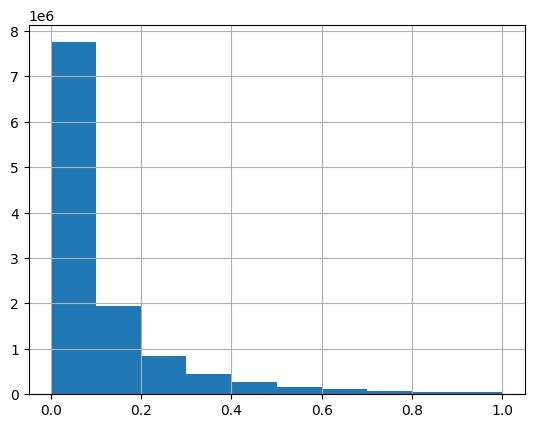

In [ ]:
genome_scores.relevance.hist()

In [ ]:
# Merge genome_scores and genome_tags
genome_merged = genome_scores.merge(genome_tags, on='tagId', how='left')

# Filter for relevance > 0.6
genome_filtered = genome_merged[genome_merged['relevance'] > 0.6]

# Sort by relevance
genome_sorted = genome_filtered.sort_values(['movieId', 'relevance'], ascending=[True, False])

# Get top 10 tags per movie
genome_top10 = genome_sorted.groupby('movieId').head(10)

# Create the desired output
movie_tags = genome_top10.groupby('movieId')['tag'].apply(list).reset_index()

movie_tags.head()


,movieId,tag
0,1,"[toys, computer animation, pixar animation, ki..."
1,2,"[adventure, jungle, children, kids, special ef..."
2,3,"[good sequel, sequel, sequels, comedy, origina..."
3,4,"[women, chick flick, girlie movie, romantic, u..."
4,5,"[good sequel, father daughter relationship, se..."


In [ ]:
content_df = unique_title_movie_df\
.merge(movie_tags, how="left", on="movieId")\
.merge(tag_lists_by_movie, how='left', on='movieId')

content_df.head()

,title,movieId,tag_x,tag_y
0,Toy Story (1995),1,"[toys, computer animation, pixar animation, ki...","[Watched, computer animation, Disney animated ..."
1,Jumanji (1995),2,"[adventure, jungle, children, kids, special ef...","[time travel, adapted from:book, board game, c..."
2,Grumpier Old Men (1995),3,"[good sequel, sequel, sequels, comedy, origina...","[old people that is actually funny, sequel fev..."
3,Waiting to Exhale (1995),4,"[women, chick flick, girlie movie, romantic, u...","[chick flick, revenge, characters, chick flick..."
4,Father of the Bride Part II (1995),5,"[good sequel, father daughter relationship, se...","[Diane Keaton, family, sequel, Steve Martin, w..."


In [ ]:
# Combine tags to a single column
def combine_tags(row):
    tags = []
    if isinstance(row['tag_x'], list):
        tags.extend([str(tag) for tag in row['tag_x']])
    if isinstance(row['tag_y'], list):
        tags.extend([str(tag) for tag in row['tag_y']]) # Convert tags in tag_y to strings
    return ' '.join(tags)

content_df['all_tags'] = content_df.apply(combine_tags, axis=1)

content_df[['movieId','all_tags']].head()

,movieId,all_tags
0,1,toys computer animation pixar animation kids a...
1,2,adventure jungle children kids special effects...
2,3,good sequel sequel sequels comedy original cra...
3,4,women chick flick girlie movie romantic unlike...
4,5,good sequel father daughter relationship seque...


### 2.4.1 Calculate top-k movies
* Create TfidfVectorizer and train it. The result should be a tfidf_matrix of  moviesXsize-of-vocabulary
* print the terms with highest and lowest idf values (hint: use `idf_` and `get_feature_names_out()`
* based on the tfIdf matrix, calculate similarity matrix of shape moviesXmovies. Use cosine similarity
* Use the function `create_top_k_similar_movies_df()` below to calculate top-k similar movies for each movie in the corpus.
* Print top 10 similar movies to 'GoldenEye (1995)'

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(content_df['all_tags'].fillna(''))

tfidf_matrix.shape

(3159, 15006)

In [ ]:
# Taking a look at tfidf_matrix

print(tfidf_matrix.nnz) # Number of non-zero elements
# Calculate and print the sparsity of the matrix
sparsity = 100.0 * tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])
print(f"Sparsity: {sparsity:.2f}%")
# Print the IDF values for each term
idf_values = tfidf_vectorizer.idf_
idf_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names_out(), 'idf': idf_values})
idf_df.sort_values(by='idf', ascending=False)


156010
Sparsity: 0.33%


,term,idf
7503,kroyer,8.365180
8256,mancha,8.365180
8231,malik,8.365180
8234,malkovitch,8.365180
8235,mall,8.365180
...,...,...
1225,based,2.254822
2752,comedy,2.232867
9742,original,2.188274
5586,good,2.030126


In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.00000000e+00, 6.46159661e-02, 8.17959885e-03, ...,
        7.99553086e-02, 1.46497270e-03, 1.25654557e-02],
       [6.46159661e-02, 1.00000000e+00, 5.84444949e-04, ...,
        1.44667871e-01, 5.35154199e-03, 7.16564133e-02],
       [8.17959885e-03, 5.84444949e-04, 1.00000000e+00, ...,
        3.47828442e-03, 2.98700372e-03, 1.00284195e-02],
       ...,
       [7.99553086e-02, 1.44667871e-01, 3.47828442e-03, ...,
        1.00000000e+00, 1.19477594e-02, 6.78874559e-02],
       [1.46497270e-03, 5.35154199e-03, 2.98700372e-03, ...,
        1.19477594e-02, 1.00000000e+00, 2.81161222e-03],
       [1.25654557e-02, 7.16564133e-02, 1.00284195e-02, ...,
        6.78874559e-02, 2.81161222e-03, 1.00000000e+00]])

In [ ]:
def create_top_k_similar_movies_df(cosine_sim, content_df, k=5):
    """
    Creates a DataFrame of top k most similar movies for each movie based on cosine similarity.

    This function takes a cosine similarity matrix and a DataFrame containing movie information
    and returns a new DataFrame where each row represents a movie and contains a list of its
    k most similar movies.

    Args:
        cosine_sim (NumPy array): The cosine similarity matrix. This matrix should have shape (n_movies, n_movies), where n_movies is the number of movies in your dataset. Each element (i, j) represents the cosine similarity between movie i and movie j.
        content_df (Pandas DataFrame): DataFrame containing movie information, including titles. This DataFrame should have a 'title' column, which is used to identify movies in the output.
        k (int, optional): The number of top similar movies to retrieve for each movie. Defaults to 5.

    Returns:
        Pandas DataFrame: A DataFrame with columns 'Movie' and 'Top_k_Similar_Movies', where 'Top_k_Similar_Movies' contains a list of the k most similar movie titles for each movie in the 'Movie' column.
    """
    # Create a Pandas Series with movie titles as index and indices as values
    indices = pd.Series(content_df.index, index=content_df['title'])

    # Create an empty list to store the results
    results = []

    # Iterate over each movie
    for idx, row in content_df.iterrows():
        # Get the pairwise similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the k most similar movies
        sim_scores = sim_scores[1:k+1]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Append the movie title, and similar movies to the result list
        results.append([row['title'], [content_df['title'].iloc[i] for i in movie_indices]])

    # Create a DataFrame from the results
    return pd.DataFrame(results, columns=['Movie', 'Top_k_Similar_Movies'])

In [ ]:
top_k_df = create_top_k_similar_movies_df(cosine_sim, content_df, k=10)
top_k_df

,Movie,Top_k_Similar_Movies
0,Toy Story (1995),"[Toy Story 2 (1999), Bug's Life, A (1998), Mon..."
1,Jumanji (1995),"[Flubber (1997), Mrs. Doubtfire (1993), Jack (..."
2,Grumpier Old Men (1995),"[Cocoon: The Return (1988), Psycho II (1983), ..."
3,Waiting to Exhale (1995),"[Bed of Roses (1996), Butcher's Wife, The (199..."
4,Father of the Bride Part II (1995),"[Father of the Bride (1991), Jerk, The (1979),..."
...,...,...
3154,Captain America: The Winter Soldier (2014),"[Captain America: The First Avenger (2011), Av..."
3155,X-Men: Days of Future Past (2014),"[X-Men: First Class (2011), X-Men (2000), X-Me..."
3156,Edge of Tomorrow (2014),"[Back to the Future (1985), Back to the Future..."
3157,Gone Girl (2014),"[Game, The (1997), Zodiac (2007), Town, The (2..."


In [ ]:
(top_k_df[top_k_df.Movie=='Matrix, The (1999)']).values

array([['Matrix, The (1999)',
        list(['Matrix Revolutions, The (2003)', 'Matrix Reloaded, The (2003)', 'Tron (1982)', 'Strange Days (1995)', 'eXistenZ (1999)', 'Thirteenth Floor, The (1999)', 'Dark City (1998)', 'Lawnmower Man, The (1992)', 'Tron: Legacy (2010)', 'Johnny Mnemonic (1995)'])]],
      dtype=object)

In [ ]:
(top_k_df[top_k_df.Movie=='GoldenEye (1995)']).values

array([['GoldenEye (1995)',
        list(['World Is Not Enough, The (1999)', 'Die Another Day (2002)', 'Dr. No (1962)', 'From Russia with Love (1963)', 'You Only Live Twice (1967)', 'Thunderball (1965)', 'Goldfinger (1964)', 'Tomorrow Never Dies (1997)', 'Live and Let Die (1973)', 'Man with the Golden Gun, The (1974)'])]],
      dtype=object)